In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import random

In [2]:
def weight_init(experts,opening,method):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return ((closing-opening)<0).astype(int)
#     elif method=='pricerel': #price relative #closing over opening
#         return (closing/opening<1).astype(int) #same as absolute
    elif method==3: #beta
        return 1


In [3]:
def rwma(filename,lossmethod,weightmethod):
    #data is an N by T array with returns for each expert/stock i in time t forming a row
    #data = np.array(data)
    #data = totalassetdata
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = opening.columns
    dates = opening.index.values
    #print(dates)
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,'equal')
    p = w/sum(w)
    
    start = 10000000
    
    #M = np.zeros(N)
    #M_wma_random = 0
    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    #allweights = []

    # iterations
    for t in range(T):
               
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        opening_prices = opening.iloc[t].values
        opening_prices[opening.iloc[t].isnull()] = 0
        if 0 not in opening_prices:
            w[w==0] = 1
        #closing_prices_na = closing.iloc[t]
        closing_prices = closing.iloc[t].values
        closing_prices[closing.iloc[t].isnull()] = 0
        #return opening_prices
        
        #portfolio value
        if t==0: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-1]))) #new opening value
        
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                q_t.append((p[j]*values[t])/k)
            else:
                q_t.append(0)
        quantities.append(q_t)

        loss = losses(opening_prices,closing_prices,lossmethod) 
        loss[np.isnan(loss)] = 0
                
        #check sum of weight updates
        #money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        money_moved = sum(np.absolute([p[i]*((1-epsilon)**loss[i]-1) for i in range(N)]))*values[t]
        
        if t==0 or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1 - epsilon)**loss[i]
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        
       
        p = w/sum(w)
        probs.append(p)
        #return p
    
    out = pd.DataFrame(probs[1:],columns=tickers,index=dates)
    #print(out)
    out['Values'] = values
    out.to_csv(f'rwma_weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction count: ',len(transaction),'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    plt.plot(values)
    plt.show()
    return values

In [13]:
filename = 'highvol_weekly.xlsx'

Final distribution:  [4.99995482e-08 5.88063312e-08 2.15321864e-07 4.02737503e-08
 6.20740509e-08 6.91643168e-08 6.55233494e-08 7.30076036e-08
 4.02737503e-08 6.55233494e-08 1.36185415e-01 1.15790410e-01
 1.22224592e-01 1.36185415e-01 1.29016304e-01 1.15790410e-01
 1.15790410e-01 1.29016304e-01]
Final transaction count:  558 total cost:  5744995.648247612
starting value:  10000000 final value:  54313876.106872834 less transaction costs:  48568880.45862522


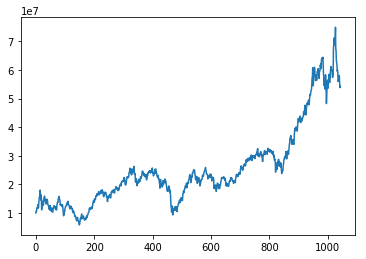

[10000000,
 10500929.280619692,
 10442063.834029414,
 10959035.460451778,
 11773348.992251493,
 11764039.378914144,
 11611301.532974511,
 12392533.079721456,
 12929190.653786086,
 11719175.723216832,
 13247061.284235429,
 14354959.083874825,
 15423351.751759311,
 15456296.443945147,
 16726475.029159253,
 17978125.4848801,
 15711427.286095016,
 16385885.933744295,
 14468931.43150389,
 15424109.458454497,
 11060404.099065067,
 12217462.289061295,
 14075099.390036754,
 14006632.593899712,
 12977103.732828815,
 13146863.664946303,
 12684454.025358243,
 14588916.215161322,
 14934958.41686133,
 15409076.631349022,
 15856703.873802429,
 14429245.006667927,
 14148392.022715807,
 14747950.26643927,
 13446388.97620941,
 13093989.772041023,
 13299504.252144633,
 13550271.881910553,
 14792782.810436023,
 13708818.015937256,
 14246091.044792693,
 13054930.468027074,
 12770903.09172453,
 12552891.57986846,
 12255136.279012013,
 11350820.467480583,
 11310479.002801454,
 11807823.60758894,
 10961701.1

In [14]:
rwma(filename,'absolute','equal')

In [16]:
data = pd.read_excel('trading_data.xlsx')
(rwma(data))

array([0.00326407, 0.01946488, 0.05213265, 0.01720955, 0.01264922,
       0.00874213, 0.00155907, 0.06270948, 0.04333975, 0.00392629,
       0.0360299 , 0.00392629, 0.00929733, 0.00502281, 0.0264824 ,
       0.08022278, 0.04609221, 0.03831812, 0.01830251, 0.09649862,
       0.09073607, 0.00444083, 0.01430692, 0.03185523, 0.01345256,
       0.02490097, 0.08022278, 0.00255149, 0.03831812, 0.00199448,
       0.06270948, 0.01720955, 0.00604185, 0.00988779, 0.01618186])

In [17]:
x=rwma(data)
out_dict = {data.columns[i]:round(x[i],5) for i in range(len(data.columns))}
out_dict

{'XOM': 0.00326,
 'SBUX': 0.01946,
 'AAPL': 0.05213,
 'GOOG': 0.01721,
 'PYPL': 0.01265,
 'FB': 0.00874,
 'NFLX': 0.00156,
 'SQ': 0.06271,
 'MSFT': 0.04334,
 'IBM': 0.00393,
 'MCD': 0.03603,
 'AMZN': 0.00393,
 'NKE': 0.0093,
 'TSLA': 0.00502,
 'EL': 0.02648,
 'CSCO': 0.08022,
 'WMT': 0.04609,
 'KO': 0.03832,
 'PM': 0.0183,
 'PG': 0.0965,
 'PEP': 0.09074,
 'GS': 0.00444,
 'BAC': 0.01431,
 'JPM': 0.03186,
 'BLK': 0.01345,
 'ICE': 0.0249,
 'SO': 0.08022,
 'PBR': 0.00255,
 'RUN': 0.03832,
 'MRO': 0.00199,
 'PFE': 0.06271,
 'ANTM': 0.01721,
 'CI': 0.00604,
 'HUM': 0.00989,
 'JNJ': 0.01618}